# Cleaning of Data

@roman 

22 June, 2023

The code aims to clean the data by removing or imputing missing values from the dataset. The dataset is a time series data of the appraised value of properties in the country of Mexico.

---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf
from itertools import product
from scipy import stats
import os

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

---
# Data

In [3]:
# read parquet
df_properties = pd.read_parquet("../../data/raw/avaluos_mex.parquet")

# make columns lower case and blank spaces to _
df_properties.columns = df_properties.columns.str.lower().str.replace(' ', '_')

# see cols
df_properties.head()

,valor_fisico_construccion,id_avaluo,fecha_avaluo,colonia,id_clase_inmueble,id_tipo_inmueble,conservacion,elevador,niveles,cve_ref_proximidad_urbana,cve_nivel_equipamiento_urbano,valor_mercado,valor_concluido_total,nivel,unidades_rentables,edad_anios,precio_m2,vida_util_remanente,cve_clasificacion_zona,cve_vigilancia,regimen_propiedad,tipo_vialidad,nivel_infraestructura,table_names-4,cuenta_predial,id_uv,id_municipio,id_entidad_f,clave_controlador,clave_valuador,id_otorgante,cp,latitud,longitud,recamaras,banos,medio_banos,estacionamiento,superficie_terreno,superficie_construida,superficie_accesoria,superficie_vendible,valor_fisico_terreno_m2
0,425901.00,30001190710390500,2019-09-06,SD,2,2,4.0,0.0,1,5,1,720691,721000,3,1,0,8633,50,2,NaN,PRIVADA INDIVIDUAL,NaN,NaN,None,NaN,30001,27,7,302349,403733,30001,29160,16.665061,-92.949447,2,1,0,1,267,83,0,83,490.0
1,1035475.65,9067200711805890,2020-04-27,SD,4,2,4.0,0.0,1,5,1,1841577,1842000,3,2,15,11091,55,3,1.0,PRIVADA INDIVIDUAL,3.0,NaN,None,NaN,9067,107,7,1844523,408526,40012,30535,16.137817,-93.000447,3,1,0,3,620,166,0,166,1142.0
2,491898.00,9067200311678970,2020-01-20,SD,4,2,4.0,0.0,1,5,1,1393971,1394000,3,1,9,18703,61,3,1.0,PRIVADA INDIVIDUAL,2.0,NaN,None,NaN,9067,8,3,408047,1641235,40012,23570,23.593706,-109.588844,1,1,0,2,561,74,0,74,1278.9
3,1611371.52,090682009R0225150,2020-05-27,SD,4,2,4.0,1.0,4,1,1,4305275,4305000,3,1,25,12353,45,4,NaN,PRIVADA INDIVIDUAL,NaN,NaN,None,NaN,9068,3,9,1742315,1400027,30001,4600,19.310875,-99.158103,2,1,0,0,143,348,0,348,8918.0
4,697726.22,090832021R0653330,2020-12-08,SD,3,2,4.0,2.0,2,2,1,826000,829000,3,1,20,5954,40,3,NaN,PRIVADA INDIVIDUAL,NaN,NaN,None,NaN,9083,51,21,1844210,1639485,30001,74585,18.510228,-98.609661,4,2,1,0,93,139,0,139,1398.0


In [4]:
# drop table_names-4, cuenta_predial, nivel_infraestructura
df_properties = df_properties.drop(columns=['table_names-4', 'cuenta_predial', 'nivel_infraestructura'])

In [5]:
# see columns
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 40 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   valor_fisico_construccion      1048575 non-null  float64       
 1   id_avaluo                      1048575 non-null  object        
 2   fecha_avaluo                   1048575 non-null  datetime64[ns]
 3   colonia                        1048575 non-null  object        
 4   id_clase_inmueble              1048575 non-null  int64         
 5   id_tipo_inmueble               1048575 non-null  int64         
 6   conservacion                   1048574 non-null  float64       
 7   elevador                       1015862 non-null  float64       
 8   niveles                        1048575 non-null  int64         
 9   cve_ref_proximidad_urbana      1048575 non-null  int64         
 10  cve_nivel_equipamiento_urbano  1048575 non-null  int64

In [6]:
# get original columns
original_cols = df_properties.columns.copy()

---
# Univariate Cleaning

## Remove Data

- The object of study are id_tipo_inmueble which are 2-4, which are houses, houses in condo and apartments. 
- The id_clase_inmueble should be on 1-7.  
- The superficie_terreno , superficie_construida , superficie_vendible   should be greater than 0. 
- The superficie_vendible   should be greater than 30m2. 
- The valor_fisico_construccion , valor_mercado  and valor_fisico_terreno_m2 should be greater than 0.   

In [7]:
# get values
valid_values = pd.Series(
    df_properties
    .agg(
        id_tipo_inmueble_between_2_4 = ('id_tipo_inmueble', lambda x: x.between(2, 4).mean()),
        id_clase_inmueble_between_1_7 = ('id_clase_inmueble', lambda x: x.between(1, 7).mean()),
        superficie_terreno_greater_than_0 = ('superficie_terreno', lambda x: (x > 0).mean()),
        superficie_construida_greater_than_0 = ('superficie_construida', lambda x: (x > 0).mean()),
        superficie_vendible_greater_than_30 = ('superficie_vendible', lambda x: (x > 30).mean()),
        valor_fisico_construccion_greater_than_0 = ('valor_fisico_construccion', lambda x: (x > 0).mean()),
        valor_mercado_greater_than_0 = ('valor_mercado', lambda x: (x > 0).mean()),
        valor_fisico_terreno_m2_greater_than_0 = ('valor_fisico_terreno_m2', lambda x: (x > 0).mean()),
        recamaras_greater_than_0 = ('recamaras', lambda x: (x > 0).mean()),
        banios_greater_than_0 = ('banos', lambda x: (x > 0).mean()),
    )
    # get diagonal and only stay with the diagonal
    .values.diagonal()
)

# set index
valid_values.index = [
    'id_tipo_inmueble_between_2_4',
    'id_clase_inmueble_between_1_7',
    'superficie_terreno_greater_than_0',
    'superficie_construida_greater_than_0',
    'superficie_vendible_greater_than_30',
    'valor_fisico_construccion_greater_than_0',
    'valor_mercado_greater_than_0',
    'valor_fisico_terreno_m2_greater_than_0',
    'recamaras_greater_than_0',
    'banios_greater_than_0'
]

# see
valid_values.to_frame().style.format("{:.4%}")

,0
id_tipo_inmueble_between_2_4,98.1488%
id_clase_inmueble_between_1_7,99.9997%
superficie_terreno_greater_than_0,99.9880%
superficie_construida_greater_than_0,99.9992%
superficie_vendible_greater_than_30,99.8957%
valor_fisico_construccion_greater_than_0,98.8488%
valor_mercado_greater_than_0,99.9989%
valor_fisico_terreno_m2_greater_than_0,95.6959%


In [8]:
# see how many rows are valid
mask = (
    (df_properties['id_tipo_inmueble'].between(2, 4)) &
    (df_properties['id_clase_inmueble'].between(1, 7)) &
    (df_properties['superficie_terreno'] > 0) &
    (df_properties['superficie_construida'] > 0) &
    (df_properties['superficie_vendible'] > 30) &
    (df_properties['valor_fisico_construccion'] > 0) &
    (df_properties['valor_mercado'] > 0) &
    (df_properties['valor_fisico_terreno_m2'] > 0)
)

# see
print(f"Rows: {mask.sum()}. Percentage Removed: {1 - mask.mean():.2%}")

Rows: 972120. Percentage Removed: 7.29%


In [9]:
# subset
df_properties = df_properties[mask].reset_index(drop=True)

## Change of Values

- The vida_utitl_remanente should be positive. If negative, then multiply by (-1) 

In [10]:
# see vida_util_remanente negative
mask = df_properties['vida_util_remanente'] < 0
df_properties[mask]

,valor_fisico_construccion,id_avaluo,fecha_avaluo,colonia,id_clase_inmueble,id_tipo_inmueble,conservacion,elevador,niveles,cve_ref_proximidad_urbana,cve_nivel_equipamiento_urbano,valor_mercado,valor_concluido_total,nivel,unidades_rentables,edad_anios,precio_m2,vida_util_remanente,cve_clasificacion_zona,cve_vigilancia,regimen_propiedad,tipo_vialidad,id_uv,id_municipio,id_entidad_f,clave_controlador,clave_valuador,id_otorgante,cp,latitud,longitud,recamaras,banos,medio_banos,estacionamiento,superficie_terreno,superficie_construida,superficie_accesoria,superficie_vendible,valor_fisico_terreno_m2
242990,337433.53,9067222413213210,2022-12-28,TLAXCALA,2,2,4.0,0.0,2,1,4,772777,773000,3,1,62,8252,-12,4,1.0,PRIVADA INDIVIDUAL,3.0,9067,28,24,1004217,500884,40012,78038,22.163480,-100.971681,2,2,0,0,56,93,0,93,7300.000000
442788,870766.89,9001231411068690,2023-04-28,PROLONGACION DEL CUARTEL VII,4,2,3.0,NaN,2,2,4,14731900,14334000,3,1,100,41741,-30,3,1.0,PRIVADA INDIVIDUAL,3.0,9001,39,14,1844602,500447,40014,44150,20.672458,-103.370686,6,3,1,3,686,343,0,343,17481.553936
507781,3848148.00,9067191111423200,2019-07-19,CENTRO,4,2,4.0,0.0,2,1,4,7954000,7954000,3,5,73,10045,-3,13,1.0,PRIVADA INDIVIDUAL,6.0,9067,20,11,801779,600403,40012,37000,21.122310,-101.680572,4,2,4,8,395,791,0,791,9566.000000
565498,952622.41,9058190910359020,2019-07-12,VISTA ALEGRE,4,2,3.0,0.0,2,2,4,4592069,4592000,3,1,71,15596,-1,3,1.0,PRIVADA INDIVIDUAL,2.0,9058,15,9,406470,1844321,40002,6860,19.408748,-99.135152,2,3,1,3,216,294,0,294,16390.000000
581619,1139647.50,9045191910498210,2019-07-19,ZONA CENTRO,4,2,4.0,0.0,2,1,4,2767721,2768000,3,1,75,9892,-5,13,1.0,PRIVADA INDIVIDUAL,3.0,9045,39,19,303842,500215,40002,64000,25.664519,-100.308078,3,2,2,2,180,279,0,279,12300.100000
634414,163244.16,9067200911727390,2020-02-24,AMERICAS UNIDAS,2,4,4.0,0.0,1,1,3,1228542,1229000,7,23,51,32521,-1,3,1.0,PRIVADA COLECTIVA,2.0,9067,14,9,903708,302810,40012,3610,19.383000,-99.142200,2,1,0,0,13,37,0,37,27000.000000
777347,944532.00,9067201111736230,2020-02-28,SAN NICOLAS ANTES ZAPIAN,3,2,4.0,0.0,2,1,4,1438134,1438000,3,1,62,5407,-2,4,1.0,PRIVADA INDIVIDUAL,3.0,9067,20,11,801779,405118,40012,37480,21.110978,-101.679411,4,4,0,2,180,223,42,265,2666.400000
781235,1156900.32,9058200410460280,2020-08-27,GUADALUPE,4,2,4.0,0.0,1,1,4,3630442,3630000,3,1,72,19825,-2,3,1.0,PRIVADA INDIVIDUAL,2.0,9058,2,4,303263,1844595,40014,24010,19.848443,-90.528873,2,1,1,0,321,170,13,183,3017.000000
785586,436063.31,9058203110438470,2020-05-22,CENTRO,4,2,7.0,0.0,1,1,4,1869555,1870000,3,1,80,16807,-10,3,1.0,PRIVADA INDIVIDUAL,2.0,9058,50,31,1844595,1639415,40044,97000,20.957739,-89.622531,1,1,0,1,377,88,22,111,3556.880000
903384,3797142.62,9092231410114580,2023-05-16,CUARTEL 1°,4,2,3.0,NaN,1,1,4,6213767,6214000,3,1,80,11658,-10,3,1.0,PRIVADA INDIVIDUAL,2.0,9092,6,14,406470,1844896,40044,46600,20.546240,-104.046066,4,3,2,0,444,296,236,533,4905.559640


In [11]:
# multiply by -1
mask = df_properties['vida_util_remanente'] < 0
df_properties.loc[mask, 'vida_util_remanente'] = (-1) * df_properties.loc[mask, 'vida_util_remanente']

In [12]:
# see
df_properties.shape

(972120, 40)

---
# Multivariate Cleaning

The following relationship should hold: 
- x['superficie_construida'] + x['superficie_accesoria'] >= x['superficie_vendible']
- The valor_concluido & valor_mercado should be near
- The valor_concluido &  superficie_vendible should be near

## Surfaces

The selling surface should be at most the sum of the built surface and the accessory surface.

In [13]:
# see case where built surface is the same as surface sold group by id_tipo_inmueble
df_properties = (
    df_properties
    .assign(
        surface_construida_accesoria=lambda x: (
            x['superficie_construida']
            + x['superficie_accesoria']
            )
    )
)

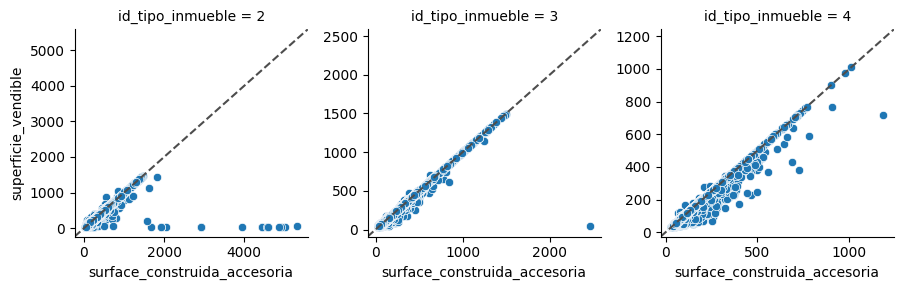

In [14]:
# see relationship between superficie_vendible and same_surface_construida_accesoria
g = sns.FacetGrid(
    df_properties,
    col='id_tipo_inmueble',
    col_wrap=5,
    sharex=False,
    sharey=False,
    )

# plot
g.map(
    sns.scatterplot,
    'surface_construida_accesoria',
    'superficie_vendible',
    )

# set same limits for each plot
for ax in g.axes:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())

# add identity line
for ax in g.axes:
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

In [15]:
# props that surface_construida_accesoria >= superficie_vendible
# TODO: check errors (maybe check type of property)
# TODO: check outliers
mask = df_properties['surface_construida_accesoria'] >= df_properties['superficie_vendible']
print(f"Rows: {mask.sum()}. Percentage Removed: {1 - mask.mean():.2%}")

Rows: 859508. Percentage Removed: 11.58%


In [16]:
# will not subset
df_properties.shape

(972120, 41)

## Pricing
The valor_concluido & valor_mercado should be near

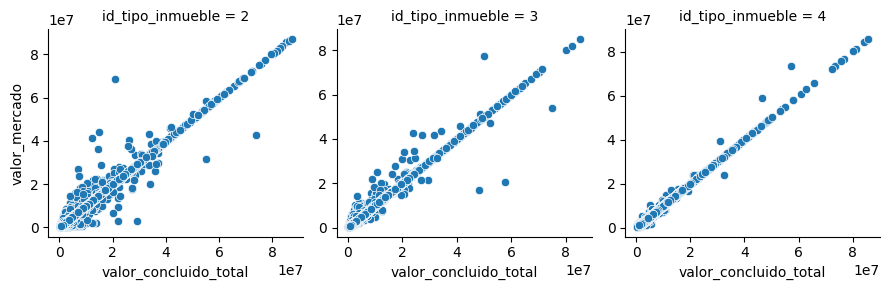

In [17]:
# see relationship between valor_concluido_total and valor_mercado
g = sns.FacetGrid(
    df_properties,
    col='id_tipo_inmueble',
    col_wrap=3,
    sharex=False,
    sharey=False,
    )

# plot
g.map(
    sns.scatterplot,
    'valor_concluido_total',
    'valor_mercado',
    )


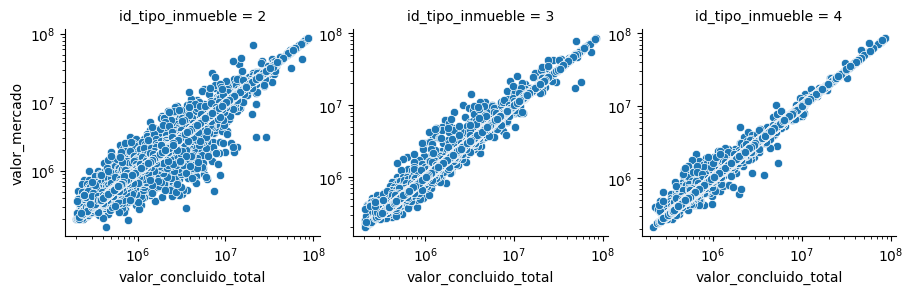

In [18]:
# see relationship between valor_concluido_total and valor_mercado
g = sns.FacetGrid(
    df_properties,
    col='id_tipo_inmueble',
    col_wrap=3,
    sharex=False,
    sharey=False,
    )

# plot
g.map(
    sns.scatterplot,
    'valor_concluido_total',
    'valor_mercado',
    )

# log scale
g.set(yscale='log', xscale='log')

We will define "near" if both values are inside the 99% confidence interval of the regression

In [19]:
# adjust regression
lm_model = smf.ols(
    formula='np.log(valor_mercado) ~ np.log(valor_concluido_total) + C(id_tipo_inmueble)',
    data=df_properties,

).fit()

# see summary
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(valor_mercado)   R-squared:                       0.997
Model:                               OLS   Adj. R-squared:                  0.997
Method:                    Least Squares   F-statistic:                 9.803e+07
Date:                   Sat, 22 Jun 2024   Prob (F-statistic):               0.00
Time:                           12:14:59   Log-Likelihood:             1.6556e+06
No. Observations:                 972120   AIC:                        -3.311e+06
Df Residuals:                     972116   BIC:                        -3.311e+06
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0358      0.001     44.593      0.000       0.034       0.037
C(id_tipo_inmueble)[T.3]         -0.0026      0.000    -23.788      0.000      -0.003      -0.002
C(id_tipo_inmueble)[T.4]         -0.0025      0.000    -22.055      0.000      -0.003      -0.002
np.log(valor_concluido_total)     0.9976   5.82e-05   1.71e+04      0.000       0.997       0.998
==============================================================================
Omnibus:                   527875.235   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4127450219.124
Skew:                          -0.740   Prob(JB):                         0.00
Kurtosis:                     322.214   Cond. No.                         249.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# log valor mercado & valor concluido
df_properties['log_valor_mercado'] = np.log(df_properties['valor_mercado'])
df_properties['log_valor_concluido_total'] = np.log(df_properties['valor_concluido_total'])

# predict values
df_properties[['log_valor_mercado_pred_lower', 'log_valor_mercado_pred_upper']] = (
    lm_model
    .get_prediction()
    .summary_frame(alpha=0.01)
    .loc[:, ['obs_ci_lower', 'obs_ci_upper']]
)

# count obs in the interval
mask = df_properties['log_valor_mercado'].between(
    df_properties['log_valor_mercado_pred_lower'],
    df_properties['log_valor_mercado_pred_upper']
)


# see
print(f"Rows: {mask.sum()}. Percentage Removed: {1 - mask.mean():.2%}")

Rows: 956699. Percentage Removed: 1.59%


In [21]:
# create new values
valor_concluido_linespace = np.linspace(
    df_properties['valor_concluido_total'].min(),
    df_properties['valor_concluido_total'].max(),
    100
    )
id_tipo_inmueble_values = df_properties['id_tipo_inmueble'].unique()

# create grid
df_new_values = pd.DataFrame(
    product(valor_concluido_linespace, id_tipo_inmueble_values),
    columns=['valor_concluido_total', 'id_tipo_inmueble']
)

# add log_valor_concluido_total
df_new_values['log_valor_concluido_total'] = np.log(df_new_values['valor_concluido_total'])

# predict
df_new_values['valor_mercado_pred'] = lm_model.predict(df_new_values)
df_new_values[['valor_mercado_lower', 'valor_mercado_upper']] = (
    lm_model
    .get_prediction(df_new_values)
    .summary_frame(alpha=0.01)
    .loc[:, ['obs_ci_lower', 'obs_ci_upper']]
)

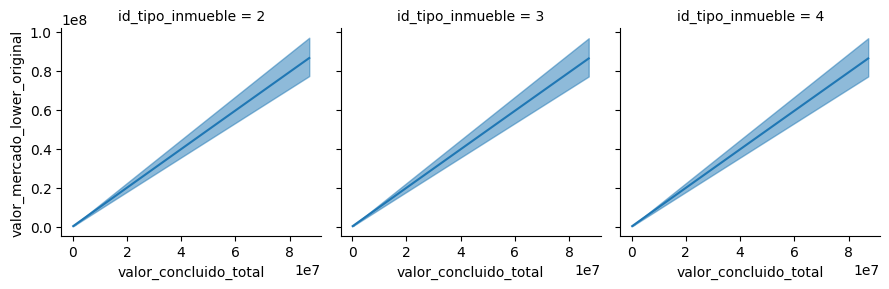

In [22]:
# plot original scale
df_new_values['valor_mercado_pred_original'] = np.exp(df_new_values['valor_mercado_pred'])
df_new_values['valor_mercado_lower_original'] = np.exp(df_new_values['valor_mercado_lower'])
df_new_values['valor_mercado_upper_original'] = np.exp(df_new_values['valor_mercado_upper'])

# plot facet by id_tipo_inmueble
g = sns.FacetGrid(
    df_new_values,
    col='id_tipo_inmueble',
    col_wrap=3,
    )

# plot
g.map(
    sns.lineplot,
    'valor_concluido_total',
    'valor_mercado_pred_original',
    )

# add confidence intervals
g.map(
    plt.fill_between,
    'valor_concluido_total',
    'valor_mercado_lower_original',
    'valor_mercado_upper_original',
    alpha=0.5,
    )

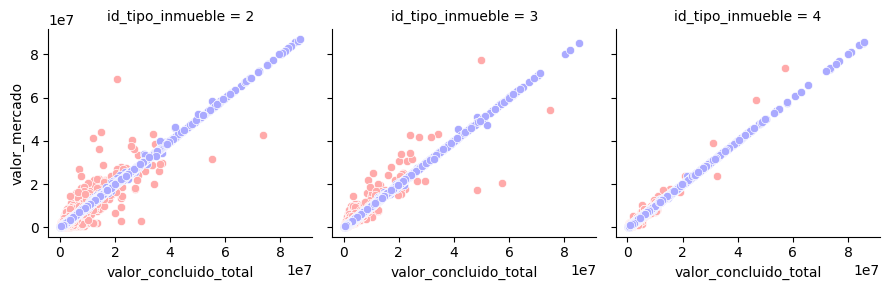

In [23]:
# plot obs which are "Outliers"
# mask
mask = df_properties['log_valor_mercado'].between(
    df_properties['log_valor_mercado_pred_lower'],
    df_properties['log_valor_mercado_pred_upper']
)

# flag
df_properties['pricing_outlier'] = 0
df_properties.loc[mask, 'pricing_outlier'] = 1

# plot
g = sns.FacetGrid(
    df_properties,
    col='id_tipo_inmueble',
    col_wrap=3,
    hue='pricing_outlier',
    palette='bwr_r',
    )

# plot
g.map(
    sns.scatterplot,
    'valor_concluido_total',
    'valor_mercado',
    alpha=1
    )


In [24]:
# subset
mask = df_properties['pricing_outlier'].eq(1)
df_properties = df_properties[mask].reset_index(drop=True)

# drop columns
df_properties = df_properties.drop(columns=[
    'log_valor_mercado',
    'log_valor_concluido_total',
    'log_valor_mercado_pred_lower',
    'log_valor_mercado_pred_upper',
    'pricing_outlier'
])

In [25]:
# shape of df
df_properties.shape

(956699, 41)

## Price per sqm

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='price_per_sqm', ylabel='Density'>

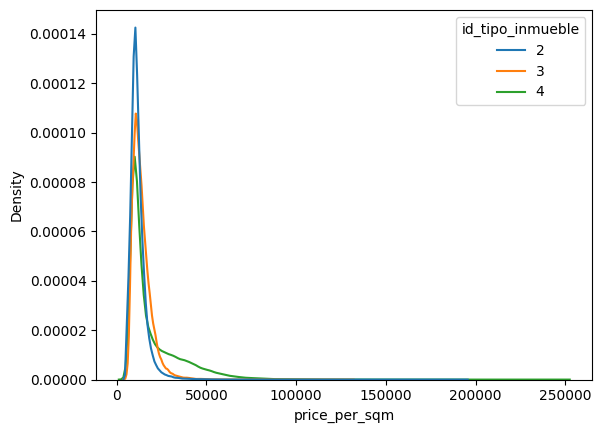

In [26]:
# manually create price per m2
df_properties['price_per_sqm'] = df_properties['valor_mercado'] / df_properties['superficie_vendible']

# see distribution
sns.kdeplot(
    data=df_properties,
    x='price_per_sqm',
    hue='id_tipo_inmueble',
    common_norm=False,
    palette='tab10',
    )

In [27]:
# see distribution
df_properties.groupby('id_tipo_inmueble')['price_per_sqm'].describe()

,count,mean,std,min,25%,50%,75%,max
id_tipo_inmueble,,,,,,,,
2,489500.0,11919.225985,4773.771914,4700.818182,9194.444444,10986.611648,13450.757576,194579.509901
3,246139.0,14033.386889,5664.368090,4941.781250,10298.292618,12742.424242,16315.789474,130655.971014
4,221060.0,19761.968586,14936.870928,5000.000000,9987.566162,13189.000000,24955.400000,248687.500000


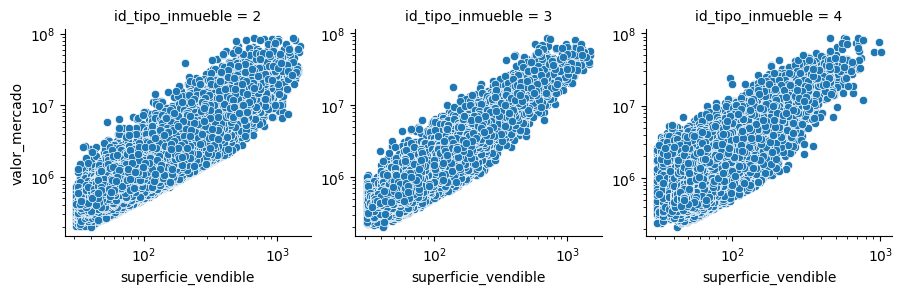

In [28]:
# see relationship between valor_mercado and superficie_vendible
g = sns.FacetGrid(
    df_properties,
    col='id_tipo_inmueble',
    col_wrap=3,
    sharex=False,
    sharey=False,
    )

# plot
g.map(
    sns.scatterplot,
    'superficie_vendible',
    'valor_mercado',
    )

# log scale
g.set(yscale='log', xscale='log')

In [30]:
# don't subset
df_properties.shape

(956699, 42)

---
# Save

In [31]:
# subset columns to original
df_properties[original_cols].head()

,valor_fisico_construccion,id_avaluo,fecha_avaluo,colonia,id_clase_inmueble,id_tipo_inmueble,conservacion,elevador,niveles,cve_ref_proximidad_urbana,cve_nivel_equipamiento_urbano,valor_mercado,valor_concluido_total,nivel,unidades_rentables,edad_anios,precio_m2,vida_util_remanente,cve_clasificacion_zona,cve_vigilancia,regimen_propiedad,tipo_vialidad,id_uv,id_municipio,id_entidad_f,clave_controlador,clave_valuador,id_otorgante,cp,latitud,longitud,recamaras,banos,medio_banos,estacionamiento,superficie_terreno,superficie_construida,superficie_accesoria,superficie_vendible,valor_fisico_terreno_m2
0,425901.00,30001190710390500,2019-09-06,SD,2,2,4.0,0.0,1,5,1,720691,721000,3,1,0,8633,50,2,NaN,PRIVADA INDIVIDUAL,NaN,30001,27,7,302349,403733,30001,29160,16.665061,-92.949447,2,1,0,1,267,83,0,83,490.0
1,1035475.65,9067200711805890,2020-04-27,SD,4,2,4.0,0.0,1,5,1,1841577,1842000,3,2,15,11091,55,3,1.0,PRIVADA INDIVIDUAL,3.0,9067,107,7,1844523,408526,40012,30535,16.137817,-93.000447,3,1,0,3,620,166,0,166,1142.0
2,491898.00,9067200311678970,2020-01-20,SD,4,2,4.0,0.0,1,5,1,1393971,1394000,3,1,9,18703,61,3,1.0,PRIVADA INDIVIDUAL,2.0,9067,8,3,408047,1641235,40012,23570,23.593706,-109.588844,1,1,0,2,561,74,0,74,1278.9
3,1611371.52,090682009R0225150,2020-05-27,SD,4,2,4.0,1.0,4,1,1,4305275,4305000,3,1,25,12353,45,4,NaN,PRIVADA INDIVIDUAL,NaN,9068,3,9,1742315,1400027,30001,4600,19.310875,-99.158103,2,1,0,0,143,348,0,348,8918.0
4,697726.22,090832021R0653330,2020-12-08,SD,3,2,4.0,2.0,2,2,1,826000,829000,3,1,20,5954,40,3,NaN,PRIVADA INDIVIDUAL,NaN,9083,51,21,1844210,1639485,30001,74585,18.510228,-98.609661,4,2,1,0,93,139,0,139,1398.0


In [32]:
# save
os.makedirs("../../data/interim", exist_ok=True)
df_properties[original_cols].to_parquet("../../data/interim/cleaned_data_s1.parquet")